## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import time


from implementation.dropout import Dropout
from utils.validate import train_and_validate

np.random.seed(42)
torch.manual_seed(42)

## Simple Distribution Validation
Test to see if both standard and inverted dropout show expected results

In [2]:
p = 0.5
input_tensor = torch.ones(500, 500) 

# inverted
drop_inv = Dropout(p=p, mode="inverted")
drop_inv.train()
out_inv = drop_inv(input_tensor)
# 50% is dropped. The mean would be 0.5, but scaling should make it close to 1
print(f"Inverted (Train) Mean: {out_inv.mean():.4f} (Expected ~1.0)")
    
drop_inv.eval()
out_inv_eval = drop_inv(input_tensor)
print(f"Inverted (Eval)  Mean: {out_inv_eval.mean():.4f} (Expected 1.0)\n")

# standard
drop_std = Dropout(p=p, mode="standard")
drop_std.train()
out_std = drop_std(input_tensor)
print(f"Standard (Train) Mean: {out_std.mean():.4f} (Expected ~0.5)")
    
drop_std.eval()
out_std_eval = drop_std(input_tensor)
# Tensors are not dropped. The mean would be 1.0, but scaling should make it close to 0.5
print(f"Standard (Eval)  Mean: {out_std_eval.mean():.4f} (Expected 0.5)")

Inverted (Train) Mean: 1.0004 (Expected ~1.0)
Inverted (Eval)  Mean: 1.0000 (Expected 1.0)

Standard (Train) Mean: 0.5001 (Expected ~0.5)
Standard (Eval)  Mean: 0.5000 (Expected 0.5)


## Fashion-MNIST validation

In [3]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)


train_loader = DataLoader(train, batch_size=1024, shuffle=True)
test_loader = DataLoader(test, batch_size=4098, shuffle=False)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [4]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

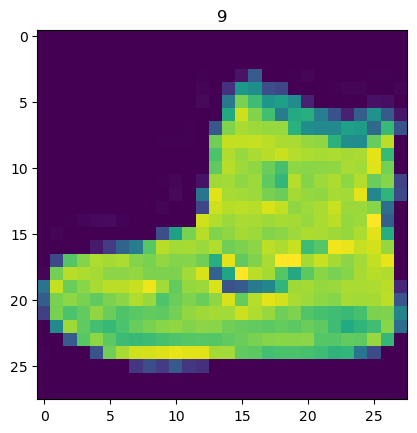

In [5]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

In [6]:
# baseline nn
class SimpleNetNoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class SimpleNetWithDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            Dropout(p),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [9]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

models_test = {
    "No Dropout": SimpleNetNoDropout(),
    "With Dropout": SimpleNetWithDropout(p=0.4),
}

for name, model in models_test.items():
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print(f"\n=== {name} ===")
    for epoch in range(1, 16):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        acc = evaluate(model, test_loader, device)

        print(f"Epoch {epoch} | Loss: {train_loss:.4f} | Test Acc: {acc:.4f}")



=== No Dropout ===
Epoch 1 | Loss: 0.8705 | Test Acc: 0.7991
Epoch 2 | Loss: 0.5130 | Test Acc: 0.8261
Epoch 3 | Loss: 0.4566 | Test Acc: 0.8336
Epoch 4 | Loss: 0.4281 | Test Acc: 0.8383
Epoch 5 | Loss: 0.4072 | Test Acc: 0.8477
Epoch 6 | Loss: 0.3943 | Test Acc: 0.8516
Epoch 7 | Loss: 0.3765 | Test Acc: 0.8553
Epoch 8 | Loss: 0.3636 | Test Acc: 0.8588
Epoch 9 | Loss: 0.3545 | Test Acc: 0.8614
Epoch 10 | Loss: 0.3445 | Test Acc: 0.8648
Epoch 11 | Loss: 0.3341 | Test Acc: 0.8673
Epoch 12 | Loss: 0.3277 | Test Acc: 0.8661
Epoch 13 | Loss: 0.3177 | Test Acc: 0.8724
Epoch 14 | Loss: 0.3118 | Test Acc: 0.8733
Epoch 15 | Loss: 0.3116 | Test Acc: 0.8707

=== With Dropout ===
Epoch 1 | Loss: 0.9442 | Test Acc: 0.7873
Epoch 2 | Loss: 0.5573 | Test Acc: 0.8196
Epoch 3 | Loss: 0.4853 | Test Acc: 0.8398
Epoch 4 | Loss: 0.4495 | Test Acc: 0.8446
Epoch 5 | Loss: 0.4204 | Test Acc: 0.8513
Epoch 6 | Loss: 0.4017 | Test Acc: 0.8562
Epoch 7 | Loss: 0.3877 | Test Acc: 0.8609
Epoch 8 | Loss: 0.3728 | Tes

In [11]:
""" 
TODO: 
- Fazer rede neural mais complexa (talvez se baseando em redes feitas em outros artigos)
- Testar torchvision.models
- Testar dataset CIFAR-10?
""" 

' \nTODO: \n- Fazer rede neural mais complexa (talvez se baseando em redes feitas em outros artigos)\n- Testar torchvision.models\n- Testar dataset CIFAR-10?\n'

In [16]:
class FastTensorDataLoader:
    def __init__(self, dataset, batch_size=1024, device='cuda'):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        all_data, all_targets = next(iter(data_loader))
        
        self.data = all_data.to(device)
        self.targets = all_targets.to(device)
        
        self.batch_size = batch_size
        self.n_samples = self.data.size(0)
    
    def __iter__(self):
        self.curr_idx = 0
        return self
    
    def __next__(self):
        if self.curr_idx >= self.n_samples:
            raise StopIteration
        
        end_idx = min(self.curr_idx + self.batch_size, self.n_samples)
        
        batch_data = self.data[self.curr_idx:end_idx]
        batch_targets = self.targets[self.curr_idx:end_idx]
        
        self.curr_idx = end_idx
        return batch_data, batch_targets

    def __len__(self):
        return (self.n_samples + self.batch_size - 1) // self.batch_size

In [17]:
def remove_dropout_layers(model):
    # recursively replaces all nn.Dropout layers with nn.Identity
    for name, module in model.named_children():
        if isinstance(module, nn.Dropout):
            setattr(model, name, nn.Identity())
        else:
            remove_dropout_layers(module)
    return model

In [ ]:
def get_vgg_model(device):
    model = models.vgg11(weights=None)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    model.features = model.features[:-1]
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.classifier[0] = nn.Linear(512, 4096) 
    model.classifier[6] = nn.Linear(4096, 10)
    return model.to(device)

def get_alexnet_model(device):
    model = models.alexnet(weights=None)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.classifier[1] = nn.Linear(256, 4096)
    model.classifier[6] = nn.Linear(4096, 10)
    return model.to(device)

def get_resnet_dropout_model(device):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity() # skip aggressive pooling
    
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 10)
    )
    return model.to(device)

Using device: cuda

--- Processing VGG11 ---

--- Training VGG11 (Drop) ---
Epoch 1/10 | Loss: 1.6117 | Test Acc: 58.09%
Epoch 2/10 | Loss: 0.7744 | Test Acc: 75.81%
Epoch 3/10 | Loss: 0.5099 | Test Acc: 83.03%
Epoch 4/10 | Loss: 0.4059 | Test Acc: 86.34%
Epoch 5/10 | Loss: 0.3168 | Test Acc: 88.49%
Epoch 6/10 | Loss: 0.2647 | Test Acc: 89.90%
Epoch 7/10 | Loss: 0.2355 | Test Acc: 89.61%
Epoch 8/10 | Loss: 0.2216 | Test Acc: 89.80%
Epoch 9/10 | Loss: 0.2054 | Test Acc: 89.68%
Epoch 10/10 | Loss: 0.1842 | Test Acc: 90.67%
Finished in 49.40s

--- Training VGG11 (No Drop) ---
Epoch 1/10 | Loss: 1.8532 | Test Acc: 45.00%
Epoch 2/10 | Loss: 0.9899 | Test Acc: 65.41%
Epoch 3/10 | Loss: 0.6785 | Test Acc: 78.09%
Epoch 4/10 | Loss: 0.4662 | Test Acc: 83.31%
Epoch 5/10 | Loss: 0.3917 | Test Acc: 86.09%
Epoch 6/10 | Loss: 0.3158 | Test Acc: 87.53%
Epoch 7/10 | Loss: 0.2604 | Test Acc: 89.57%
Epoch 8/10 | Loss: 0.2237 | Test Acc: 89.53%
Epoch 9/10 | Loss: 0.2103 | Test Acc: 90.31%
Epoch 10/10 | L

TypeError: unhashable type: 'dict'

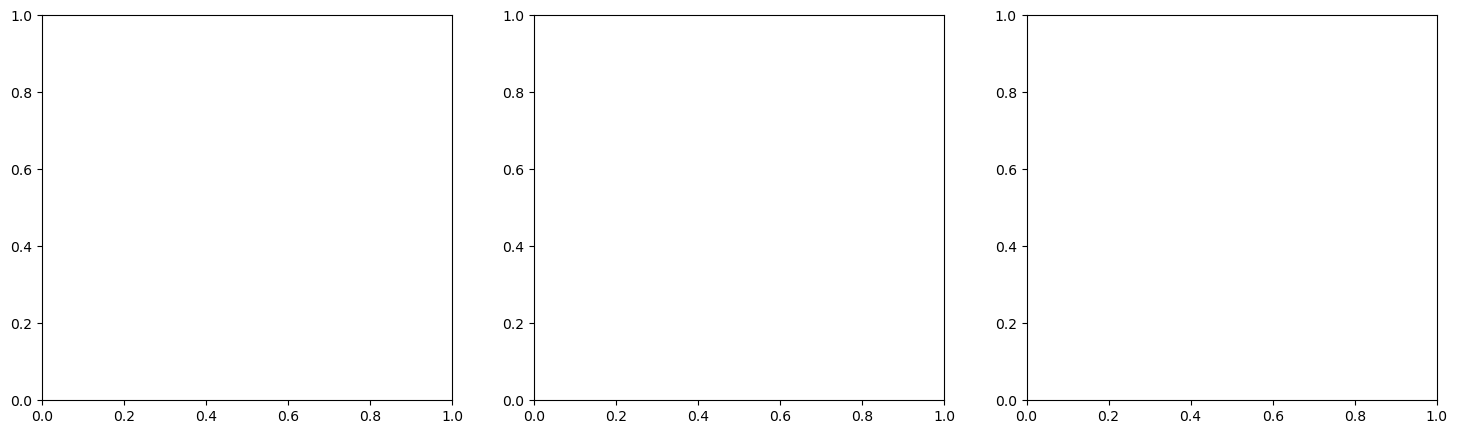

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = FastTensorDataLoader(train_data, batch_size=2048, device=device)
test_loader = FastTensorDataLoader(test_data, batch_size=4096, device=device)

model_list = [
        (get_vgg_model, "VGG11"),
        (get_alexnet_model, "AlexNet"),
        (get_resnet_dropout_model, "ResNet18 (Modified)")
    ]

results = {}
for model_func, model_name in model_list:
    print(f"\n--- Processing {model_name} ---")
        
    model_drop = model_func(device)
    hist_drop = train_and_validate(f"{model_name} (Drop)", model_drop, train_loader, test_loader)
        
    model_no_drop = model_func(device)
    remove_dropout_layers(model_no_drop)
    hist_no_drop = train_and_validate(f"{model_name} (No Drop)", model_no_drop, train_loader, test_loader)
        
    results[model_name] = (hist_drop, hist_no_drop)

drop {'loss': [1.6116890112559001, 0.7744257330894471, 0.5098532299200694, 0.4058897912502289, 0.3167811527848244, 0.2647044430176417, 0.23548468897740046, 0.22162313063939412, 0.20542166580756505, 0.1842343293130398], 'acc': [58.09, 75.81, 83.03, 86.34, 88.49, 89.9, 89.61, 89.8, 89.68, 90.67]}
drop {'loss': [2.0261345307032266, 1.0482603192329407, 0.6868913928667705, 0.5440742741028468, 0.4562963962554932, 0.3883983890215556, 0.34532886147499087, 0.31661033431688945, 0.2937625403205554, 0.27226639886697135], 'acc': [47.2, 72.14, 78.44, 81.51, 84.78, 86.29, 87.5, 88.52, 88.82, 89.6]}
drop {'loss': [0.6696094115575154, 0.2787672966718674, 0.2080859884619713, 0.17443730334440868, 0.14066634103655815, 0.12246774683396021, 0.10305368565022946, 0.08433026541024446, 0.06287003221611182, 0.04492872059345245], 'acc': [86.27, 90.24, 90.28, 89.59, 89.98, 82.19, 88.3, 90.2, 88.97, 89.62]}


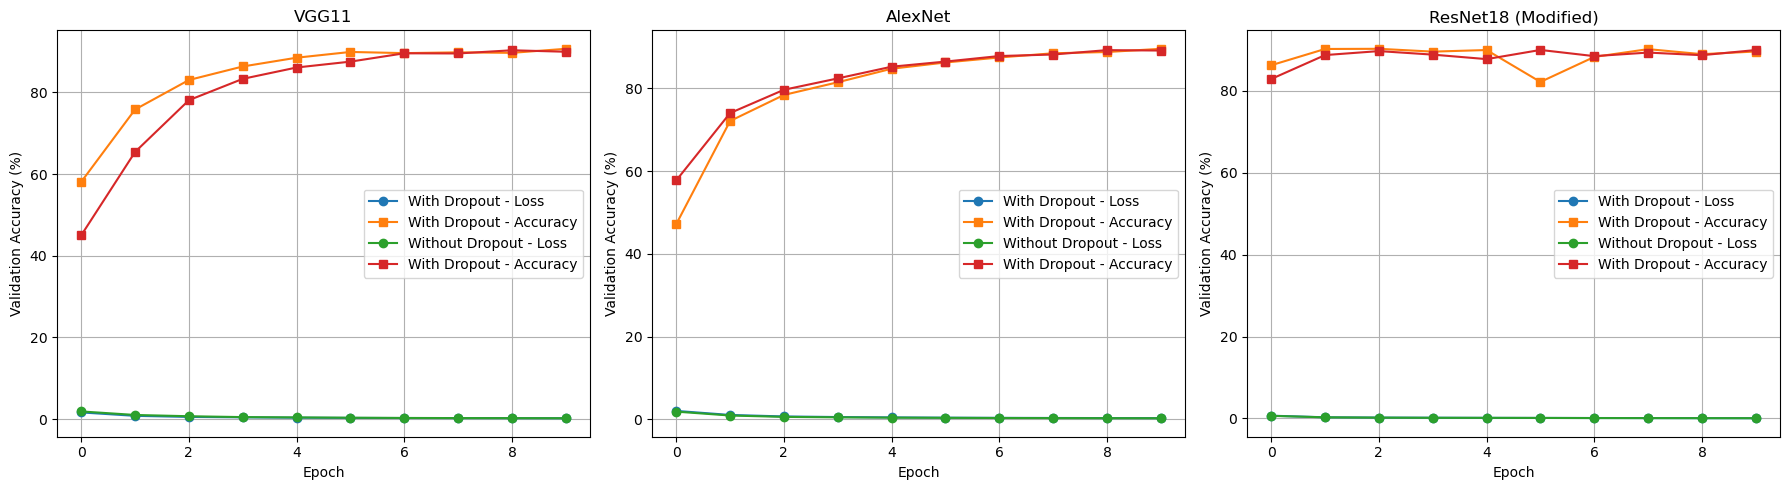

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
for i, (model_name, (drop, no_drop)) in enumerate(results.items()):
    print('drop', drop)
    ax = axes[i]
    ax.plot(drop["loss"], label="With Dropout - Loss", marker="o")
    ax.plot(drop["acc"], label="With Dropout - Accuracy", marker="s")

    ax.plot(no_drop["loss"], label="Without Dropout - Loss", marker="o")
    ax.plot(no_drop["acc"], label="With Dropout - Accuracy", marker="s")

    ax.set_title(model_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.legend()
    ax.grid(True)
    # ax.set_ylim(80, 95) 

plt.tight_layout()
plt.show()